In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Rescaling

In [2]:
"GPU available" if tf.config.list_physical_devices("GPU") else "Not available"

GPU available


In [3]:
image_size = (50, 50)
batch_size = 512
class_names = ["idc", "non_idc"]
num_classes = len(class_names)

In [4]:
train_set = keras.utils.image_dataset_from_directory(
    directory="../data/dataset/train",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    class_names=class_names
)

val_set = keras.utils.image_dataset_from_directory(
    directory="../data/dataset/val",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    class_names=class_names
)

Found 126056 files belonging to 2 classes.
Found 15758 files belonging to 2 classes.


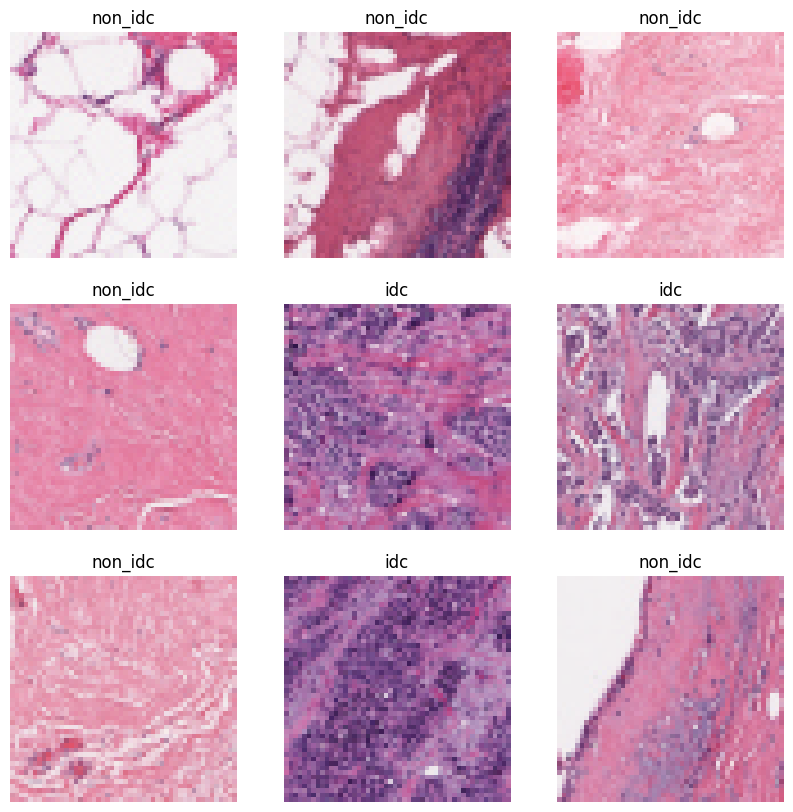

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_set.class_names[int(labels[i])])
        plt.axis("off")

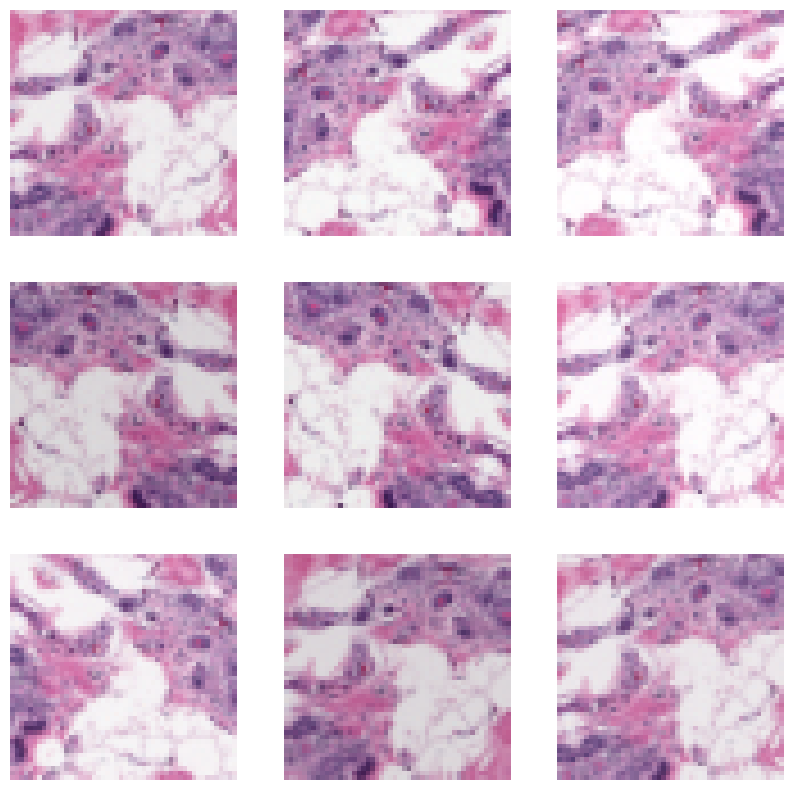

In [6]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomContrast(0.1),
        keras.layers.RandomBrightness(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

train_set = train_set.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_set = train_set.prefetch(tf.data.AUTOTUNE)
val_set = val_set.prefetch(tf.data.AUTOTUNE)

In [7]:
def build_model():
    inputs = Input(shape=image_size + (3,))

    # x = data_augmentation(inputs)
    x = Rescaling(1.0 / 255)(inputs)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = Dense(units, activation=activation)(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [8]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 50, 50, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                        

In [ ]:
epochs = 1

H = model.fit(
    train_set,
    epochs=epochs,
    validation_data=val_set,
)

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("train_loss_acc_plot.png")

In [ ]:
test_set = keras.utils.image_dataset_from_directory(
    directory="../data/dataset/test",
    label_mode="binary",
    batch_size=batch_size,
    image_size=image_size,
    class_names=class_names
)

y_pred = []
y_true = []

for images, labels in test_set:
    
    predictions = model.predict(images)
    predictions = [1 if x > 0.5 else 0 for x in predictions]

    y_pred.extend(predictions)
    y_true.extend(labels.numpy().astype("int"))

In [ ]:
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("classification_report.csv")